In [1]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Segmentation data
pupil_xyr = [196.26, 139.09,  42.00]
iris_xyr  = [191.54, 142.90, 118.30]

# Output dilation
dil = 0.25

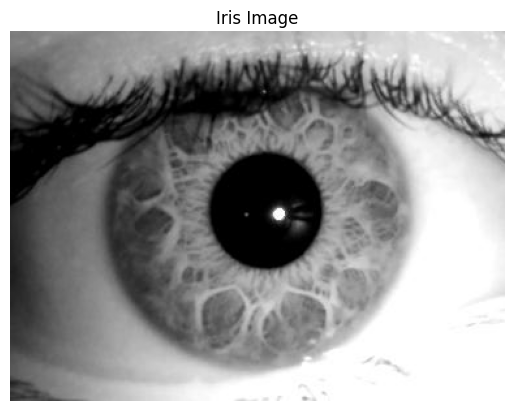

In [3]:
# Open input image
im1 = Image.open('../samples/NIR_1.png')

plt.imshow(im1, cmap='gray')
plt.title('Iris Image')
plt.axis('off')
plt.show()

In [4]:
# Get input shape
im1 = np.array(im1)
shape = im1.shape
if len(shape) == 2:
    im1 = np.expand_dims(im1, 2)
M, N, chanels = im1.shape

im1.shape

(284, 380, 1)

In [5]:
# Get original pupuil and iris radii:
rp1 = pupil_xyr[2]
ri = iris_xyr[2]

print('Iris radius: {}'.format(ri))

Iris radius: 118.3


In [6]:
# Compute output pupil radius:
rp2 = dil*ri

print('Pupil radius: {} --> {}'.format(rp1,rp2))

Pupil radius: 42.0 --> 29.575


In [7]:
# Slope for lineal transformation:
m = (ri-rp1)/(ri-rp2)

In [8]:
# Create putput image:
im2 = im1.copy()

im2.shape

(284, 380, 1)

In [9]:
# Pupil mask
pupil_mask = Image.new('L', (N, M), (0))
draw = ImageDraw.Draw(pupil_mask)
xp = pupil_xyr[0]
yp = pupil_xyr[1]
rp = 0.97*rp2
draw.ellipse((xp-rp, yp-rp, xp+rp, yp+rp), fill=(255), outline=(0))
pupil_mask = np.array(pupil_mask) > 0

pupil_mask.shape

(284, 380)

In [10]:
# Iris mask
iris_mask = Image.new('L', (N, M), (0))
draw = ImageDraw.Draw(iris_mask)
draw.ellipse((xp-ri, yp-ri, xp+ri, yp+ri), fill=(255), outline=(0))
iris_mask = np.array(iris_mask) > 0
iris_mask[pupil_mask] = 0

iris_mask.shape

(284, 380)

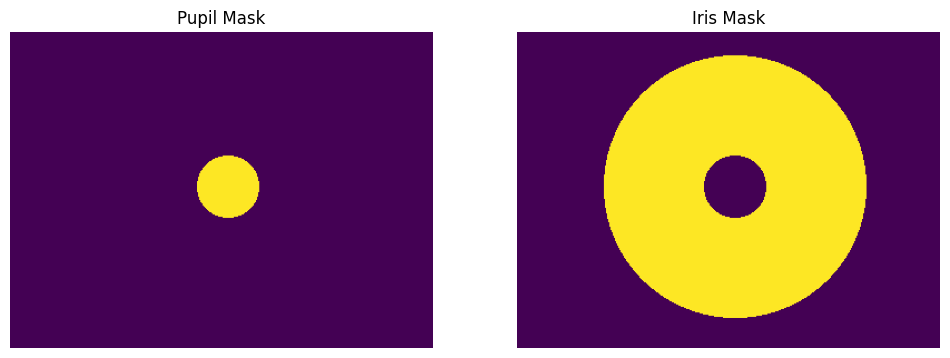

In [11]:
# Show masks
fig, axs = plt.subplots(1,2, figsize=(12, 6))

axs[0].imshow(pupil_mask)
axs[0].axis('off')
axs[0].set_title('Pupil Mask')

axs[1].imshow(iris_mask)
axs[1].axis('off')
axs[1].set_title('Iris Mask')

plt.show()

In [12]:
# Sample pixels in the iris
v, u = np.where(iris_mask)

xp = u - pupil_xyr[0]
yp = v - pupil_xyr[1]
rp = np.sqrt(xp**2 + yp**2)
th = np.arctan2(yp,xp)
r = m*(rp-rp2) + rp1
x = (r*np.cos(th) + pupil_xyr[0]).astype(np.int32)
y = (r*np.sin(th) + pupil_xyr[1]).astype(np.int32)

im2[v,u,:] = im1[y,x,:]

In [13]:
# Sample pixels in the pupil
v, u = np.where(pupil_mask)

xp = u - pupil_xyr[0]
yp = v - pupil_xyr[1]
rp = np.sqrt(xp**2 + yp**2)
th = np.arctan2(yp,xp)
r = rp1*rp/rp2
x = (r*np.cos(th)+pupil_xyr[0]).astype(np.int32)
y = (r*np.sin(th)+pupil_xyr[1]).astype(np.int32)

im2[v,u,:] = im1[y,x,:]

In [14]:
# Convert to PIL image
if chanels == 1:
    im2 = np.squeeze(im2, axis=2)
im2 = Image.fromarray(im2)

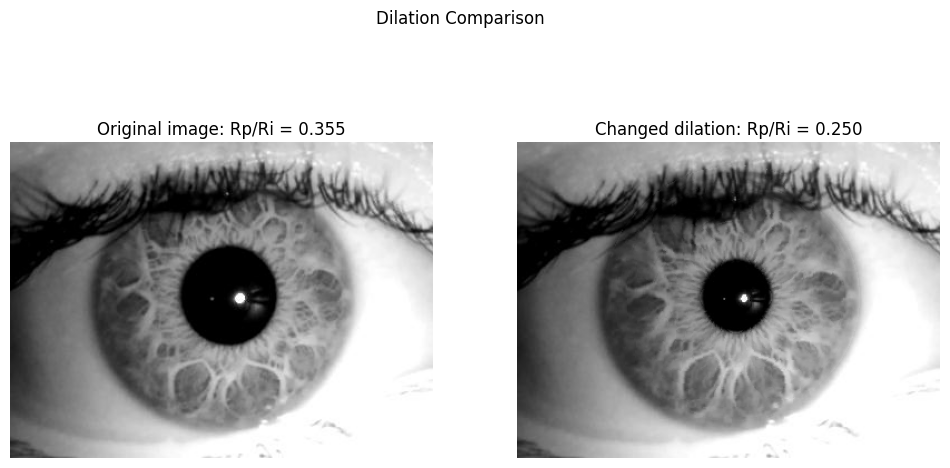

In [15]:
# Show results
fig, axs = plt.subplots(1,2, figsize=(12, 6))
fig.suptitle('Dilation Comparison')

axs[0].imshow(im1, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original image: Rp/Ri = {:0.3f}'.format(rp1/ri))

axs[1].imshow(im2, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Changed dilation: Rp/Ri = {:0.3f}'.format(dil))

plt.show()